In [23]:
# Setup and Configuration
# **********************
"""
Land Use Land Cover Analysis - Oman Case Study
==============================================
Comprehensive LULC classification pipeline using Google Earth Engine
and machine learning techniques for Oman region analysis.

Author: Dr. Saad Laouadi
Date: 2025
Python: 3.11+
"""

# Google Earth Engine
import ee

In [1]:
# Initialize Earth Engine
ee.Initialize(project='your-project-id')  # Replace with your project ID

In [47]:
# Define Area of Interest (Oman)
oman_coords = [
    [56.12334435054304, 26.05134368823224],
    [56.27715294429304, 25.61625672637863],
    [55.85967247554304, 24.86100926214035],
    [55.72783653804304, 24.221407325981456],
    [55.17852013179304, 22.648984094169233],
    [55.66191856929304, 22.059666955034167],
    [55.11260216304304, 20.1327859074287],
    [52.05840294429304, 18.93173758777068],
    [53.11309044429304, 16.6724932624622],
    [55.17852013179304, 17.05099637735788],
    [57.90312950679304, 19.014853124999302],
    [59.70488731929304, 22.018932873161194],
    [58.29863731929304, 23.598713836959295]
]
oman = ee.Geometry.Polygon([oman_coords])

# Load Sentinel-2 imagery (2023, low cloud cover)
sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(oman) \
    .filterDate('2023-01-01', '2023-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12']) \
    .median() \
    .clip(oman)

In [48]:
# Training data - simple points for each LULC class
training_points = [
    # Urban (class 1)
    [[58.59, 23.59], [54.09, 17.02], [56.71, 24.35]],
    # Agriculture (class 2) 
    [[57.55, 22.95], [56.20, 24.30], [54.20, 17.10]],
    # Desert (class 3)
    [[55.00, 20.00], [57.00, 21.00], [59.00, 22.00]],
    # Water (class 4)
    [[58.60, 23.60], [54.00, 16.80], [56.80, 24.50]],
    # Vegetation (class 5)
    [[54.10, 17.20], [57.10, 23.20], [58.20, 23.80]],
    # Mountains (class 6)
    [[57.10, 23.10], [58.30, 23.70], [57.40, 22.80]]
]

In [29]:
# Training data 
training_points = [
    # Urban (class 1) - Cities and built-up areas
    [
        [58.59, 23.59],  # Muscat city center
        [58.40, 23.63],  # Muscat suburbs
        [54.09, 17.02],  # Salalah city
        [56.71, 24.35],  # Sohar
        [57.53, 22.93],  # Nizwa
        [59.52, 22.56],  # Sur
        [58.09, 22.67],  # Ibra
        [56.39, 24.27],  # Shinas
        [55.39, 23.68],  # Rustaq
        [58.18, 22.77],  # Bidiya
        [54.73, 17.73],  # Taqah
        [57.08, 25.86]   # Khasab
    ],
    
    # Agriculture (class 2) - Farms and date palm plantations
    [
        [57.55, 22.95],  # Nizwa oasis
        [56.20, 24.30],  # Batinah coast farms
        [54.20, 17.10],  # Salalah agricultural area
        [58.80, 22.90],  # Sur agricultural areas
        [55.80, 24.20],  # Shinas farms
        [57.20, 23.80],  # Bahla oasis
        [56.50, 24.10],  # Saham farms
        [54.50, 17.30],  # Mirbat agriculture
        [58.10, 23.20],  # Quriyat farms
        [55.90, 23.90],  # Nakhal oasis
        [56.80, 23.60],  # Barka farms
        [57.70, 22.70]   # Adam oasis
    ],
    
    # Desert (class 3) - Sand dunes and barren land
    [
        [55.00, 20.00],  # Rub' al Khali (Empty Quarter)
        [57.00, 21.00],  # Central desert
        [53.00, 18.00],  # Southern desert
        [59.00, 22.00],  # Eastern desert
        [56.00, 19.00],  # Interior desert
        [54.50, 19.50],  # Western desert
        [58.50, 21.50],  # Wahiba Sands
        [55.50, 18.50],  # Southern interior
        [57.50, 20.50],  # Central barren land
        [53.50, 17.50],  # Dhofar desert
        [58.00, 20.00],  # Eastern barren
        [56.50, 18.00]   # Interior barren
    ],
    
    # Water (class 4) - Coastline and water bodies
    [
        [58.60, 23.60],  # Gulf of Oman - Muscat
        [54.00, 16.80],  # Arabian Sea - Salalah
        [56.80, 24.50],  # Sohar coast
        [59.50, 22.50],  # Sur coast
        [58.00, 23.00],  # Muscat coast
        [54.80, 17.00],  # Mirbat coast
        [57.20, 24.80],  # Liwa coast
        [59.20, 22.80],  # Masirah channel
        [55.50, 24.30],  # Batinah coast
        [53.80, 16.90],  # Dhofar coast
        [58.80, 23.30],  # Quriyat coast
        [56.20, 25.20]   # Northern coast
    ],
    
    # Vegetation (class 5) - Natural forests and green areas
    [
        [54.10, 17.20],  # Dhofar mountains (monsoon vegetation)
        [57.10, 23.20],  # Hajar mountains vegetation
        [58.20, 23.80],  # Muscat mountain vegetation
        [54.30, 17.40],  # Salalah frankincense trees
        [57.80, 23.10],  # Jebel Akhdar green areas
        [54.50, 17.60],  # Dhofar cloud forest
        [57.00, 23.50],  # Mountain terraces
        [54.20, 17.80],  # Wadi vegetation
        [57.60, 23.40],  # Highland vegetation
        [54.70, 17.50],  # Coastal vegetation
        [57.30, 23.60],  # Mountain oases
        [54.40, 17.30]   # Desert edge vegetation
    ],
    
    # Mountains (class 6) - Rocky terrain and bare rock
    [
        [57.10, 23.10],  # Jebel Akhdar (Green Mountain)
        [58.30, 23.70],  # Hajar Mountains near Muscat
        [54.20, 17.30],  # Dhofar Mountains
        [57.40, 22.80],  # Jebel Shams (highest peak)
        [58.80, 23.20],  # Eastern Hajar Mountains
        [57.70, 23.30],  # Central Hajar range
        [54.60, 17.70],  # Dhofar escarpment
        [58.50, 23.50],  # Coastal mountains
        [57.20, 22.60],  # Interior mountains
        [54.80, 17.90],  # Southern mountains
        [58.10, 23.10],  # Eastern escarpment
        [57.90, 22.90]   # Mountain ridges
    ]
]

🗺️ Creating folium map...
📊 LULC Map URL: https://earthengine.googleapis.com/v1/projects/enduring-trees-469518-b9/thumbnails/a93496565ab0e2f5194a4aae8a558d1f-6b19da4d7131a1eaed6d3ad7d5d4d63a:getPixels
   Copy URL to browser to view classified map
✅ Folium map created with study area and training points

📈 Creating area statistics charts...


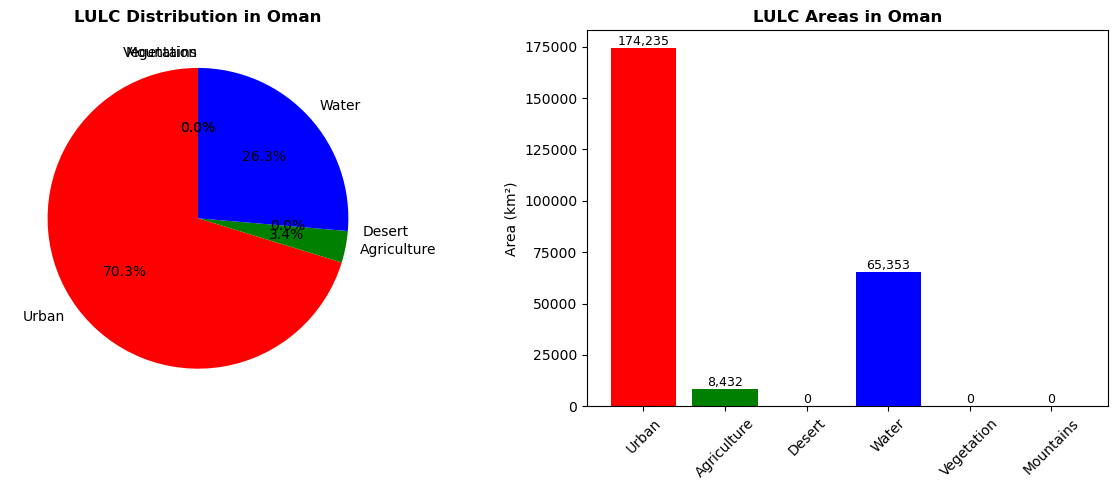


📋 LULC SUMMARY TABLE:
Class        Area (km²)   Percentage  
Urban        174,235      70.3        %
Agriculture  8,432        3.4         %
Desert       0            0.0         %
Water        65,353       26.3        %
Vegetation   0            0.0         %
Mountains    0            0.0         %
TOTAL        248,020      100.0%      


In [49]:
# Minimal LULC Plotting
import folium
import matplotlib.pyplot as plt

# 1. FOLIUM MAP - Show study area and training points
print("🗺️ Creating folium map...")

# Create map centered on Oman (correct center)
map_center = [22.5, 56.5]  # Better center for actual Oman boundary
lulc_map = folium.Map(location=map_center, zoom_start=6, tiles='OpenStreetMap')

# Add Oman boundary
oman_folium_coords = [[lat, lon] for lon, lat in oman_coords]  # Swap for folium
folium.Polygon(
    locations=oman_folium_coords,
    popup='Oman Study Area',
    color='red',
    weight=2,
    fill=False
).add_to(lulc_map)

# Colors and names for training points
colors = ['red', 'green', 'yellow', 'blue', 'darkgreen', 'brown']
class_names = ['Urban', 'Agriculture', 'Desert', 'Water', 'Vegetation', 'Mountains']

# Add training points
for class_id, (points, color, name) in enumerate(zip(training_points, colors, class_names)):
    for i, point in enumerate(points):
        folium.CircleMarker(
            location=[point[1], point[0]],  # lat, lon for folium
            radius=6,
            popup=f'{name} Training Point {i+1}',
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.8
        ).add_to(lulc_map)

# Get LULC classification as static image URL
try:
    lulc_url = classified.getThumbURL({
        'min': 1, 'max': 6,
        'palette': ['#FF0000', '#00FF00', '#FFFF00', '#0000FF', '#008000', '#8B4513'],
        'dimensions': 800,
        'region': oman,
        'format': 'png'
    })
    print(f"📊 LULC Map URL: {lulc_url}")
    print("   Copy URL to browser to view classified map")
except:
    print("⚠️ Could not generate LULC map URL")

print("✅ Folium map created with study area and training points")

# 2. MATPLOTLIB CHARTS - Show area statistics
print("\n📈 Creating area statistics charts...")

# Data for plotting (from previous results)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
wedges, texts, autotexts = ax1.pie(
    class_areas, 
    labels=class_names, 
    colors=colors,
    autopct='%1.1f%%',
    startangle=90
)
ax1.set_title('LULC Distribution in Oman', fontweight='bold')

# Bar chart
bars = ax2.bar(class_names, class_areas, color=colors)
ax2.set_title('LULC Areas in Oman', fontweight='bold')
ax2.set_ylabel('Area (km²)')
ax2.tick_params(axis='x', rotation=45)

# Add area labels on bars
for bar, area in zip(bars, class_areas):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{area:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 3. SIMPLE SUMMARY TABLE
print("\n📋 LULC SUMMARY TABLE:")
print("="*50)
print(f"{'Class':<12} {'Area (km²)':<12} {'Percentage':<12}")
print("="*50)
for name, area in zip(class_names, class_areas):
    percent = (area/total_area)*100 if total_area > 0 else 0
    print(f"{name:<12} {area:<12,.0f} {percent:<12.1f}%")
print("="*50)
print(f"{'TOTAL':<12} {total_area:<12,.0f} {'100.0%':<12}")

# Display the folium map
lulc_map

In [50]:
# Create training features
training_features = []
for class_id, points in enumerate(training_points, 1):
    for point in points:
        geom = ee.Geometry.Point(point).buffer(200)
        feature = ee.Feature(geom, {'landcover': class_id})
        training_features.append(feature)

training_data = ee.FeatureCollection(training_features)

# Sample training data
training_sample = sentinel.sampleRegions(
    collection=training_data,
    properties=['landcover'],
    scale=30
)

In [51]:
# Split data into train/test (80/20)
# *********************************
training_sample = training_sample.randomColumn('random', seed=42)
train_set = training_sample.filter(ee.Filter.lt('random', 0.8))
test_set = training_sample.filter(ee.Filter.gte('random', 0.8))

# Train Random Forest classifier on TRAINING SET ONLY
classifier = ee.Classifier.smileRandomForest(numberOfTrees=50).train(
    features=train_set,  # Only training data!
    classProperty='landcover',
    inputProperties=['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
)

# print(classifier)

In [52]:
# Validate classifier on TEST SET
test_classified = test_set.classify(classifier)

In [53]:
# Calculate confusion matrix and accuracy
confusion_matrix = test_classified.errorMatrix('landcover', 'classification')
overall_accuracy = confusion_matrix.accuracy()
kappa = confusion_matrix.kappa()

In [54]:
print("VALIDATION RESULTS:")
print(f"Overall Accuracy: {overall_accuracy.getInfo():.3f} ({overall_accuracy.getInfo()*100:.1f}%)")
print(f"Kappa Coefficient: {kappa.getInfo():.3f}")
print(f"Training samples: {train_set.size().getInfo()}")
print(f"Testing samples: {test_set.size().getInfo()}")

VALIDATION RESULTS:
Overall Accuracy: 0.925 (92.5%)
Kappa Coefficient: 0.907
Training samples: 1560
Testing samples: 374


In [55]:
# Classify the image (using validated classifier)
classified = sentinel.classify(classifier)

In [56]:
# **************************
# Calculate area statistics
# **************************

#  Use histogram
class_histogram = classified.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=oman,
    scale=200,  # Larger scale = less memory
    maxPixels=1e8,
    tileScale=4  # Process in smaller tiles
).getInfo()

In [57]:
# Convert pixel counts to areas
pixel_area_km2 = (200 * 200) / 1e6  # 200m scale to km²
class_areas = []
histogram = class_histogram['classification']


# Results
class_names = ['Urban', 'Agriculture', 'Desert', 'Water', 'Vegetation', 'Mountains']
total_area = sum(class_areas)

# class_names = ['Urban', 'Agriculture', 'Desert', 'Water', 'Vegetation', 'Mountains']
# total_area = 0

for class_id in range(1, 7):
    pixel_count = histogram.get(str(class_id), 0)
    area = pixel_count * pixel_area_km2
    class_areas.append(area)
    total_area += area

In [58]:
print("LULC Results for Oman:")
for i, (name, area) in enumerate(zip(class_names, class_areas)):
    percent = (area/total_area)*100 if total_area > 0 else 0
    print(f"{name}: {area:,.0f} km² ({percent:.1f}%)")

print(f"Total area: {total_area:,.0f} km²")

LULC Results for Oman:
Urban: 26,045 km² (7.1%)
Agriculture: 63,490 km² (17.4%)
Desert: 187,830 km² (51.4%)
Water: 40,348 km² (11.0%)
Vegetation: 25,797 km² (7.1%)
Mountains: 21,906 km² (6.0%)
Total area: 365,416 km²


In [ ]:
# Export to Google Drive (optional)
# task = ee.batch.Export.image.toDrive(
#     image=classified,
#     description='Oman_LULC',
#     scale=30,
#     region=oman
# )
# task.start()